# cml1 - Immobilienrechner
# 2.2 Bestmögliches Regressionsmodell - kaggle-Contest

Entwickle mit beliebigen Algorithmen das bestmögliche Modell im Sinne des Mean absolute percentage error (MAPE). Vergleiche dabei mindestens drei algorithmische Ansätze, wobei ein multiples lineares Modell Teil davon sein soll als Benchmark. Untersuche die ‘Variable Importance’ für dein bestes Modell.

Abgabe

Notebook und daraus erstellter Bericht (ohne Code) als pdf, welche die Entwicklung deines besten Modells, sowie der zwei weiteren Modelle dokumentiert, inklusive verwendeter Features, Preprocessing, Model Selection Prozess und Untersuchung der ‘Variable Importance’.

Eingabe der Vorhersage des Preises für den Testdatensatz mit deinem bestmöglichen Modell auf kaggle.

### MAPE - Metrik

Der Mean Absolute Percentage Error (MAPE) ist eine Metrik zur Beurteilung der Genauigkeit von Vorhersagemodellen. MAPE gibt den durchschnittlichen prozentualen Fehler zwischen den beobachteten (tatsächlichen) Werten und den vorhergesagten Werten an. Er wird häufig in der Zeitreihenanalyse und bei Prognosemodellen verwendet, besonders wenn es wichtig ist, die Genauigkeit von Vorhersagen in Bezug auf die tatsächlichen Werte in Prozent auszudrücken.

Die Formel zur Berechnung von MAPE ist:

$$MAPE = \frac{1}{n} \sum_{i=1}^{n}\frac{|y_i - \hat{y}_i|}{y_i}* 100$$

wobei: 
- $y_i$ der tatsächliche Wert zum Zeitpunkt t ist.
- $\hat{y}_i$ der vorhergesagte Wert zum Zeitpunkt t ist.
- $n$ die Gesamtanzahl der Beobachtungen ist.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
import xgboost as xgb

df = pd.read_csv('../data/immo_data_clean.csv', low_memory=False)
print(df.shape)

(21466, 47)


## Korrelationen

In diesem Abschnitt werden wir hochkorrelierte Merkmale identifizieren. Dies ist ein wichtiger Schritt bei der Auswahl von Merkmalen. Die Logik dahinter ist, dass zwei (oder mehr) Variablen, die hoch korreliert sind, redundante Informationen enthalten, was für einige Algorithmen des maschinellen Lernens, insbesondere die lineare Regression, problematisch sein kann.

In [2]:
# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# df without categorical columns
df_num = df.drop(categorical_cols, axis=1)

In [3]:
# Compute the correlation matrix
correlation_matrix = df[numerical_cols].corr()

# Find features that have a correlation greater than 0.8 with another feature
highly_correlated_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            highly_correlated_features.add(colname)

highly_correlated_features = list(highly_correlated_features)
highly_correlated_features

['gde_workers_total',
 'RiversAndLakesM',
 'WorkplaceDensityS',
 'ForestDensityM',
 'NoisePollutionRailwayM',
 'gde_pop_per_km2',
 'NoisePollutionRoadM',
 'PopulationDensityS',
 'WorkplaceDensityM',
 'ForestDensityS',
 'PopulationDensityM',
 'NoisePollutionRoadS',
 'gde_population',
 'gde_private_apartments']

Wir haben mehrere Merkmale identifiziert, die eine Korrelation von mehr als 0.8 mit mindestens einem anderen Merkmal aufweisen.

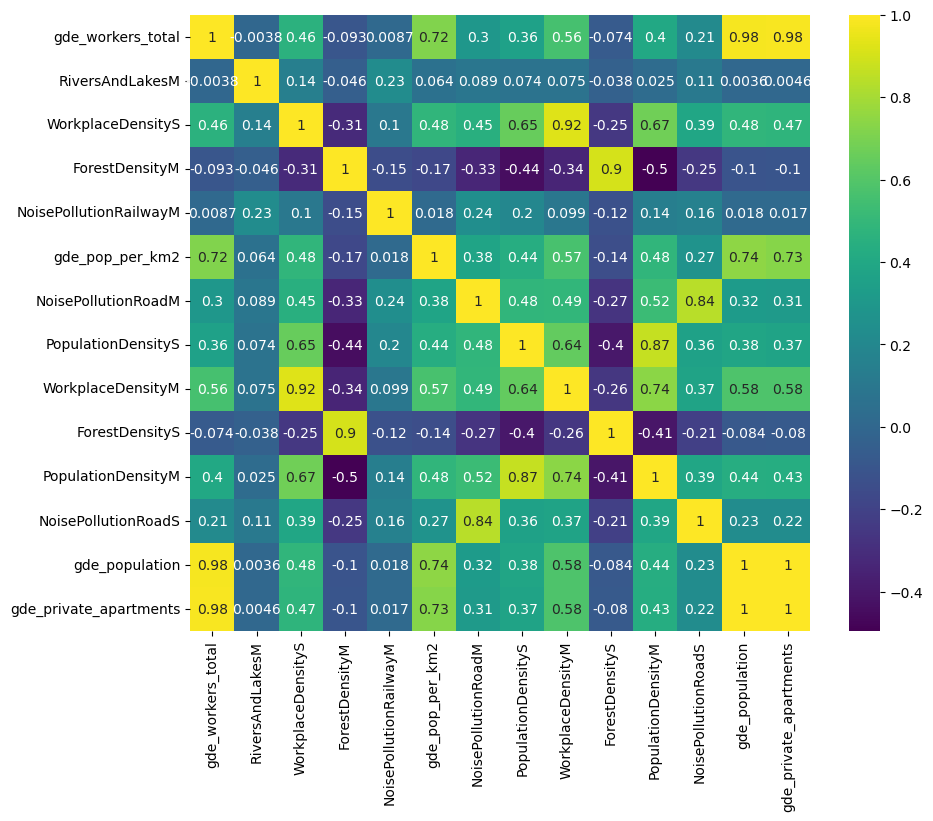

In [4]:
correlation_matrix = df_num[highly_correlated_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis')
plt.show()

Here are the pairs of correlated features:

- ForestDensityM & ForestDensityS

- gde_workers_total & gde_population
- gde_workers_total & gde_private_apartments

- PopulationDensityM & PopulationDensityS

- NoisePollutionRoadS & NoisePollutionRoadM

- WorkplaceDensityM & WorkplaceDensityS


## Feature Importance

To determine the importance of each feature we will use the xgboost and random forest libraries and then compare the results.

In [5]:
X = df_num.drop("price_cleaned", axis=1)
y = df_num["price_cleaned"]

### XGBoost

In [6]:
# Instantiate the XGBRegressor
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)

# fit the model
xg_reg.fit(X, y);

# Get F-scores from the XGBoost model
f_scores = xg_reg.get_booster().get_score(importance_type='weight')

# Convert the dictionary to a dataframe and sort
df_xgb = pd.DataFrame(list(f_scores.items()), columns=['Feature', 'F-Score']).sort_values(by='F-Score', ascending=False)
df_xgb.head(10)

,Feature,F-Score
2,Living_area_unified,76.0
5,Plot_area_unified,69.0
0,Zip,49.0
6,Rooms_new,40.0
23,gde_tax,28.0
22,gde_social_help_quota,26.0
18,gde_foreigners_percentage,24.0
1,Year built:,24.0
20,gde_pop_per_km2,20.0
17,gde_empty_apartments,19.0


#### Random Forest

In [7]:
# Handle missing values by imputation (using median strategy for simplicity)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=10, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

rf_importances = rf.feature_importances_

# Convert to DataFrame
df_rf = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)

df_rf.head(10)

,Feature,Importance
2,Living_area_unified,0.477325
5,Plot_area_unified,0.076283
24,gde_tax,0.048666
0,Zip,0.046186
20,gde_pop_per_km2,0.031311
18,gde_foreigners_percentage,0.029290
6,Rooms_new,0.027776
13,gde_area_forest_percentage,0.022281
23,gde_social_help_quota,0.019536
15,gde_area_settlement_percentage,0.016691


Wir wollen nun die beiden Dataframes mergen. Es ist jedoch zu beachten, dass die Bibliotheken verschiedene MEtriken verwenden, um die Wichtigkeit der Features zu berechnen. 

Eine Möglichkeit, die beiden Wichtigkeitsmetriken zu kombinieren, wäre, sie zu normalisieren (so dass sie Werte zwischen 0 und 1 haben) und dann einen Durchschnittswert für jedes Feature zu berechnen. Das würde uns eine kombinierte Rangliste der Features liefern.

In [8]:
# Normalize the importance metrics
df_xgb['F-Score_normalized'] = df_xgb['F-Score'] / df_xgb['F-Score'].sum()
df_rf['Importance_normalized'] = df_rf['Importance'] / df_rf['Importance'].sum()

# Merge dataframes on 'Feature'
df_features = df_xgb.merge(df_rf, on="Feature", how="outer")

# Calculate average importance
df_features['Average_Importance'] = (df_features['F-Score_normalized'] + df_features['Importance_normalized']) / 2

# Sort by average importance
df_features = df_features.sort_values(by='Average_Importance', ascending=False)

# Keep only required columns
df_features = df_features[['Feature', 'Average_Importance']]

df_features.head(10)

,Feature,Average_Importance
0,Living_area_unified,0.307131
1,Plot_area_unified,0.100303
2,Zip,0.067237
3,Rooms_new,0.049924
4,gde_tax,0.049558
6,gde_foreigners_percentage,0.036266
8,gde_pop_per_km2,0.033673
5,gde_social_help_quota,0.033191
7,Year built:,0.027868
10,gde_average_house_hold,0.022621


Die obige Tabelle zeigt die Merkmale in der Reihenfolge ihrer Wichtigkeit, wie sie vom Random-Forest-Modell ermittelt wurde. Die wichtigsten Merkmale haben die höchsten Wichtigkeits-Scores.

- `Living_area_unified` ist das wichtigste Merkmal, das einen erheblichen Teil der Variabilität von `price_cleaned` erklärt.
- `Plot_area_unified`, `Zip` und `Rooms_new` sind die nächsten drei wichtigen Merkmale.

Wir können jetzt die wichtigsten Merkmale auswählen und den Rest entfernen.

In [9]:
cols = list(df_features.head(10)['Feature'].values)
cols.append('price_cleaned')
df_model = df[cols]
df_model

,Living_area_unified,Plot_area_unified,Zip,Rooms_new,gde_tax,gde_foreigners_percentage,gde_pop_per_km2,gde_social_help_quota,Year built:,gde_average_house_hold,price_cleaned
0,100.0,NaN,5023,3.5,5.89,9.255663,376.829268,2.234259,NaN,2.23,1150000.0
1,156.0,222.0,5023,4.5,5.89,9.255663,376.829268,2.234259,NaN,2.23,1420000.0
2,93.0,NaN,5000,2.5,6.05,21.358623,1704.700162,3.549010,NaN,2.01,720000.0
3,154.0,370.0,5023,4.5,5.89,9.255663,376.829268,2.234259,NaN,2.23,1430000.0
4,142.0,NaN,5022,4.5,6.30,15.901990,511.008403,1.708126,NaN,2.28,995000.0
...,...,...,...,...,...,...,...,...,...,...,...
21461,102.0,140.0,9470,4.5,5.75,38.153380,785.642633,2.078299,1920.0,2.30,475000.0
21462,250.0,NaN,9500,5.5,6.51,27.793249,211.024918,2.670723,2022.0,2.49,1490000.0
21463,240.0,455.0,9500,5.5,6.51,27.793249,211.024918,2.670723,1966.0,2.49,1450000.0
21464,175.0,NaN,9548,5.5,6.23,25.222883,350.520833,2.090460,2022.0,2.45,1290000.0


In [10]:
df_model.isna().sum()

Living_area_unified            903
Plot_area_unified            13761
Zip                              0
Rooms_new                      694
gde_tax                          0
gde_foreigners_percentage        0
gde_pop_per_km2                  0
gde_social_help_quota            0
Year built:                  14533
gde_average_house_hold           0
price_cleaned                    0
dtype: int64

## Multiple Linear Regression (Benchmark)

In [11]:
def calc_metrics(y_true, y_pred):
    mape = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 4)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 4)
    r2 = round(r2_score(y_true, y_pred), 4)
    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_predictions(y_test, y_pred, title):
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[0])
    ax[0].set_xlabel('Actual')
    ax[0].set_ylabel('Predicted')
    ax[0].set_title('Actual vs Predicted {}'.format(title))

    sns.residplot(x=y_test,  y=y_pred, scatter_kws={'alpha': 0.1}, ax=ax[1])
    ax[1].set_xlabel('Residuals')
    ax[1].set_ylabel('Fitted Values')
    ax[1].set_title('Residuals Distribution')

    sns.histplot((y_test - y_pred), ax=ax[2])
    ax[2].set_title('Residuals Histogram')
    ax[2].set_xlabel('Residuals')
    ax[2].set_ylabel('Frequency')

    plt.show()

{'mape': 86.5539, 'rmse': 1442060.6137, 'r2': 0.4116}


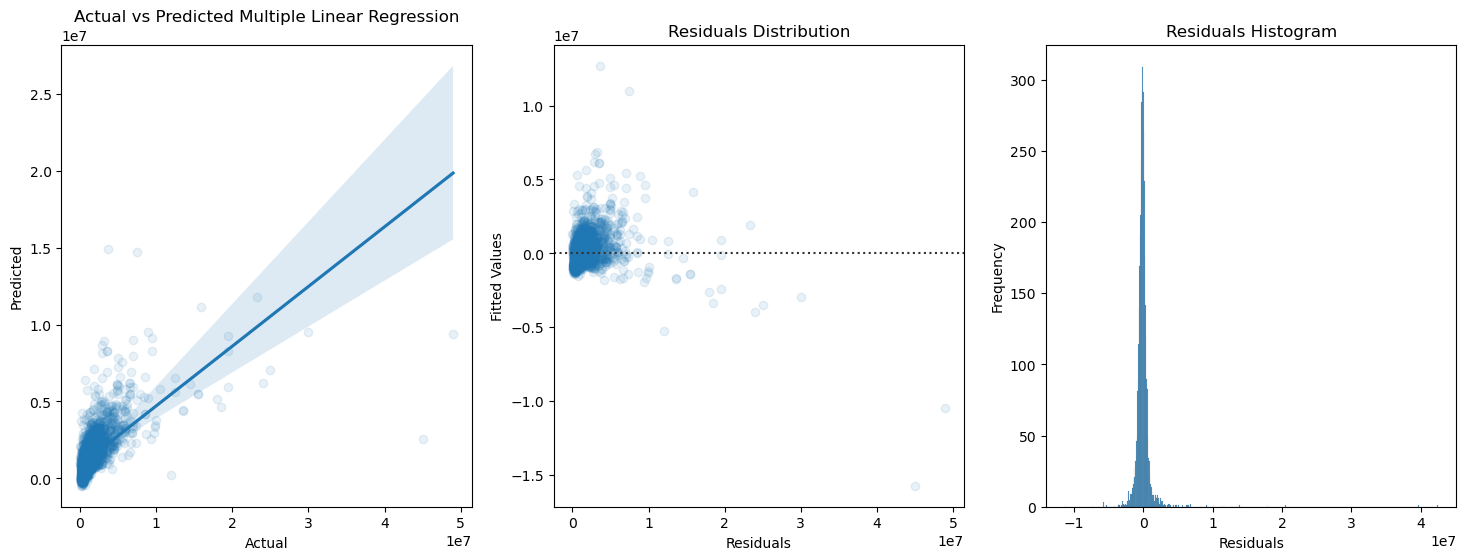

In [12]:
X = df_model.drop("price_cleaned", axis=1)
y = df_model["price_cleaned"]

# Handle missing values by imputation (using median strategy)
imputer = SimpleImputer(strategy="median")
X_imputed = imputer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Train a multiple linear regression model
lin_reg_multi = LinearRegression()
lin_reg_multi.fit(X_train, y_train)

# Predict on test set
y_pred = lin_reg_multi.predict(X_test)

print(calc_metrics(y_test, y_pred))
plot_predictions(y_test, y_pred, 'Multiple Linear Regression')

Die Vorhersagen weichen im Durchschnitt um 86% von den tatsächlichen Werten ab, was auf ein ungenaues Modell hinweist.

### Ridge Regression

### XGBoost Modell

{'mape': 68.8383, 'rmse': 1124259.4077, 'r2': 0.6424}


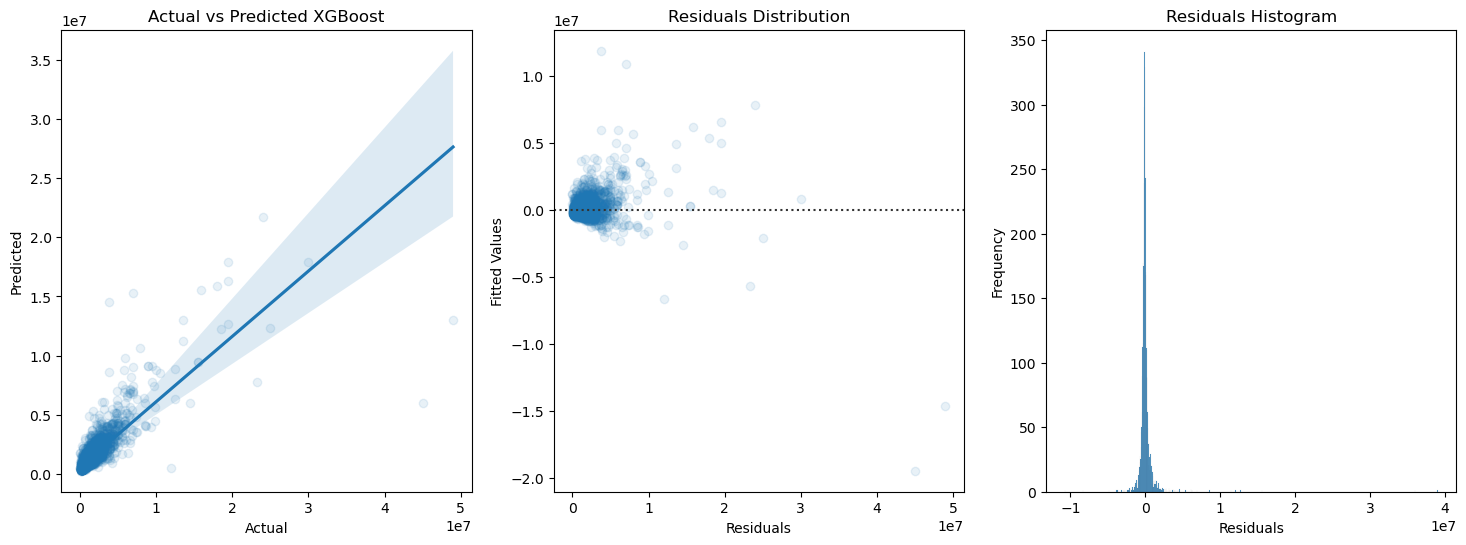

In [13]:
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=42)
xg_reg.fit(X_train, y_train)
y_pred = xg_reg.predict(X_test)

print(calc_metrics(y_test, y_pred))
plot_predictions(y_test, y_pred, 'XGBoost')

### Ridge Regression

{'mape': 86.5516, 'rmse': 1442058.9532, 'r2': 0.4117}


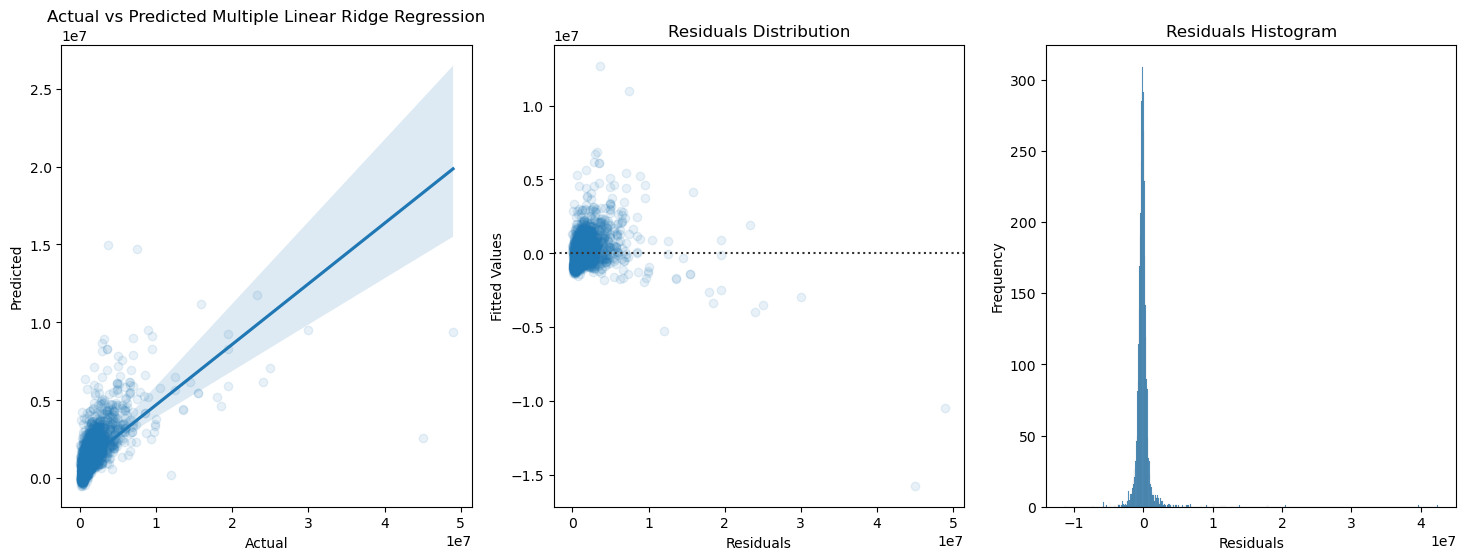

In [14]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)

print(calc_metrics(y_test, y_pred_ridge))
plot_predictions(y_test, y_pred_ridge, 'Multiple Linear Ridge Regression')

{'mape': 72.9147, 'rmse': 1436321.4292, 'r2': 0.4163}


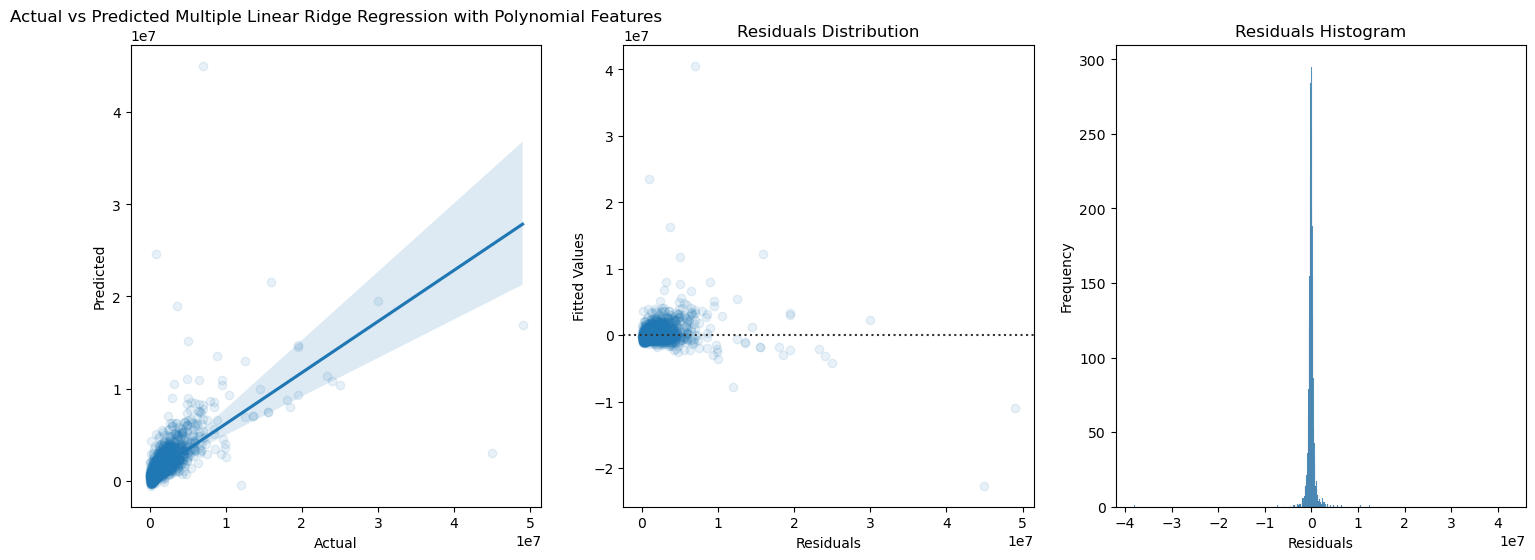

In [15]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge

# Feature scaling and polynomial features
scaler = StandardScaler()
poly = PolynomialFeatures(degree=2)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_poly, y_train)
y_pred_ridge = ridge.predict(X_test_poly)

print(calc_metrics(y_test, y_pred_ridge))
plot_predictions(y_test, y_pred_ridge, 'Multiple Linear Ridge Regression with Polynomial Features')

### Lasso Regression

{'mape': 86.5537, 'rmse': 1442060.4893, 'r2': 0.4116}


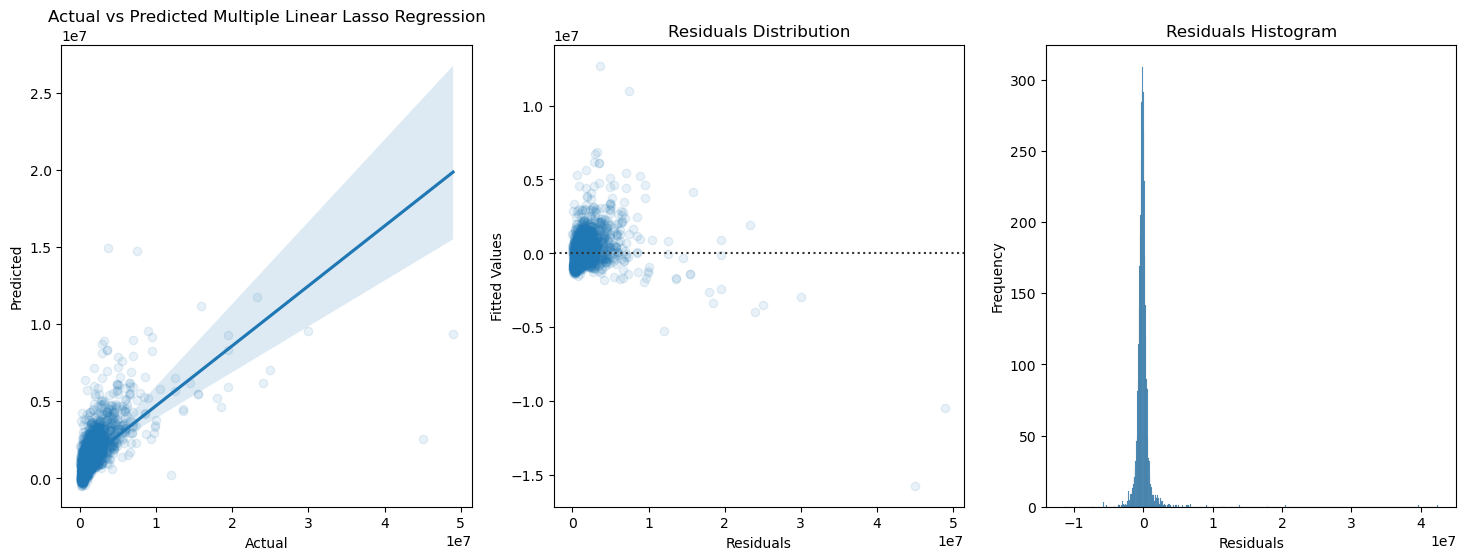

In [16]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)

print(calc_metrics(y_test, y_pred_lasso))
plot_predictions(y_test, y_pred_lasso, 'Multiple Linear Lasso Regression')

### Random Forest

{'mape': 68.6499, 'rmse': 1014690.6986, 'r2': 0.7087}


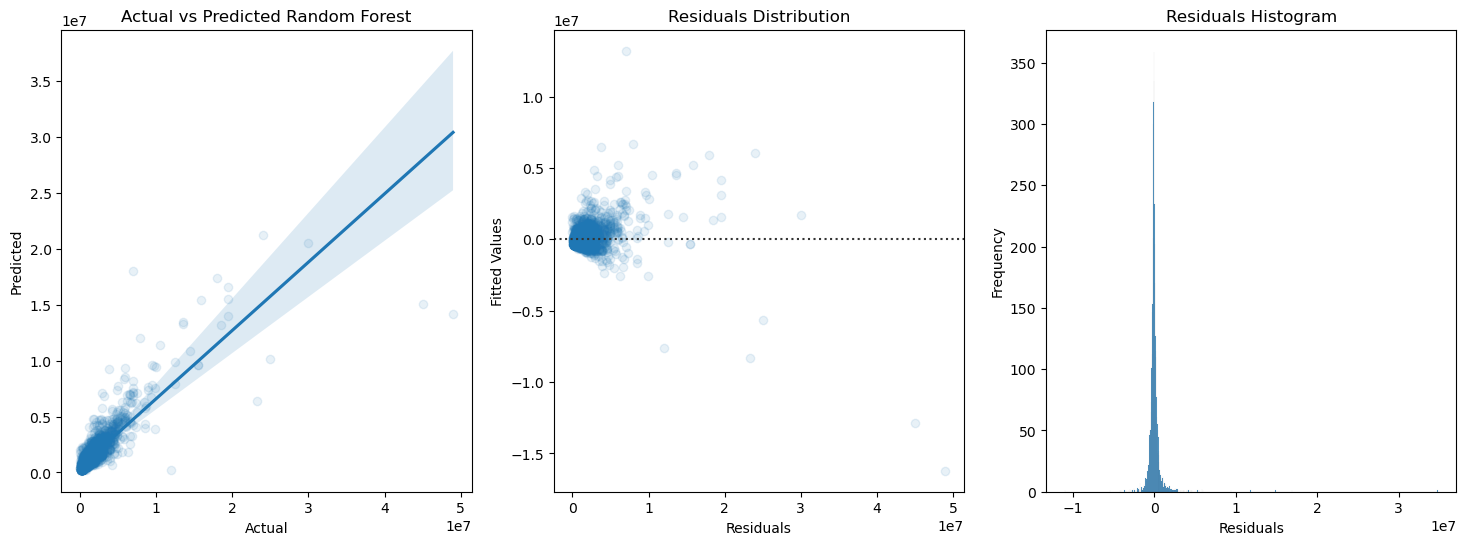

In [17]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print(calc_metrics(y_test, y_pred_rf))
plot_predictions(y_test, y_pred_rf, 'Random Forest')

### Hist Gradient Boosting Regressor

## Genauer Anschauen:
### Hist Gradient Boosting Regressor
### Regularisierungen
### Hyperparameter Tuning